In [101]:
# Enhanced Factor Timing Strategy
import numpy as np
import pandas as pd
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class FactorTimingStrategy:
    """
    Enhanced Factor Timing Strategy with improved validation and analytics
    """
    
    def __init__(self, factor_returns, predictors, rolling_window=240, validation_window=12, 
                 shrinkage_grid=np.linspace(0.1, 10, 20), min_periods=60, predictor_lag=1):
        self.rolling_window = rolling_window
        self.validation_window = validation_window
        self.shrinkage_grid = shrinkage_grid
        self.min_periods = min_periods

        # Store and preprocess data
        self.factor_returns = factor_returns.copy()
        self.predictors = predictors.shift(predictor_lag)
        # self.predictors = self._prepare_predictors(predictors)
        # Align data to same index (intersection)
        common_index = self.factor_returns.index.intersection(self.predictors.index)
        self.factor_returns = self.factor_returns.loc[common_index]
        self.predictors = self.predictors.loc[common_index]

        self.portfolio_returns = []
        self.selected_k_values = []
        self.weights_history = []

        print(f"Initialized with {len(self.factor_returns)} periods")
        print(f"Predictors lagged by {predictor_lag} period(s)")
        
    def create_timing_portfolios(self, factor_returns, predictors):
        """Create timing portfolios by interacting factors with predictors"""
        timing_returns = {}
        for f_name in factor_returns.columns:
            #timing_returns[f"{f_name}_{"Original"}"] = factor_returns[f_name]
            for p_name in predictors.columns:
                # Predictors are already lagged in __init__, so no need to shift again
                timing_returns[f"{f_name}_{p_name}"] = (
                    factor_returns[f_name] * predictors[p_name]
                )
        return pd.DataFrame(timing_returns)
    
    def compute_shrunk_cov(self, X):
        """Compute shrunk covariance matrix using Ledoit-Wolf estimator"""
        X_clean = X.dropna()
        if len(X_clean) < self.min_periods:
            raise ValueError(f"Insufficient data: {len(X_clean)} < {self.min_periods}")
        
        lw = LedoitWolf().fit(X_clean)
        return lw.covariance_, lw.location_
    
    def compute_ridge_weights(self, T, mu, Sigma, shrink_k, diag_penalty):
        """Compute portfolio weights with ridge regularization"""
        # T = len(mu)
        penalty_matrix = np.zeros_like(Sigma)
        np.fill_diagonal(penalty_matrix, diag_penalty)
        penalty_matrix[:, :len(self.factor_returns.columns)] = 0
        
        # Ridge regularization
        Sigma_shrunk = Sigma + shrink_k / T * penalty_matrix
        
        # Solve for optimal weights
        try:
            weights = np.linalg.solve(Sigma_shrunk, mu)
            # weights = np.linalg.inv(Sigma_shrunk) @ mu
        except np.linalg.LinAlgError:
            # Fallback to pseudo-inverse if singular
            weights = np.linalg.pinv(Sigma_shrunk) @ mu
        
        return weights
    
    def compute_sharpe(self, returns, periods=12):
        """Compute annualized Sharpe ratio"""
        if returns.std() == 0:
            return 0
        # Assuming monthly data, annualize
        return (returns.mean() * periods) / (returns.std() * np.sqrt(periods))
    
    def compute_max_drawdown(self, returns):
        """Compute maximum drawdown"""
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        return drawdown.min()

    def compute_performance_metrics(self, returns, periods=12):
        """Compute comprehensive performance metrics"""
        metrics = {}
        
        # Basic metrics
        metrics['Total Return'] = (1 + returns/100).prod() - 1
        metrics['Annualized Return'] = (1 + returns.mean()/100) ** periods - 1
        metrics['Annualized Volatility'] = (returns/100).std() * np.sqrt(periods)
        metrics['Sharpe Ratio'] = self.compute_sharpe(returns, periods)
        
        # Risk metrics
        metrics['Max Drawdown'] = self.compute_max_drawdown(returns)
        metrics['Skewness'] = stats.skew(returns.dropna())
        metrics['Kurtosis'] = stats.kurtosis(returns.dropna())
        metrics['VaR (5%)'] = np.percentile(returns.dropna(), 5)
        
        return metrics
    
    def backtest(self, factor_returns, predictors):
        """Run the complete backtesting procedure"""
        print("Starting Factor Timing Backtest...")
        print(f"Data period: {self.factor_returns.index[0]} to {self.factor_returns.index[-1]}")
        print(f"Factors: {list(self.factor_returns.columns)}")
        print(f"Predictors: {list(self.predictors.columns)}")
        
        # Reset storage
        self.portfolio_returns = []
        self.selected_k_values = []
        self.weights_history = []
        
        # Main rolling loop
        total_periods = len(self.factor_returns) - self.rolling_window - self.validation_window
        
        for i, t in enumerate(range(self.rolling_window, 
                                   len(self.factor_returns) - self.validation_window)):
            
            if i % 12 == 0:  # Progress update every year
                print(f"Processing period {i+1}/{total_periods} "
                      f"({self.factor_returns.index[t + self.validation_window]})")
            
            # Define time periods
            train_idx = slice(t - self.rolling_window, t)
            val_idx = slice(t, t + self.validation_window)
            test_idx = t + self.validation_window
            
            try:
                # Create training data
                G_train = self.create_timing_portfolios(self.factor_returns.iloc[train_idx], 
                                                        self.predictors.iloc[train_idx])

                # Compute covariance and mean
                Sigma, mu = self.compute_shrunk_cov(G_train)
                diag_penalty = np.diag(Sigma)
                
                # Validation loop to choose optimal k
                best_k = None
                best_sr = -np.inf
                
                for k in self.shrinkage_grid:
                    w = self.compute_ridge_weights(len(G_train), mu, Sigma, k, diag_penalty)

                    # Validation performance
                    G_val = self.create_timing_portfolios(self.factor_returns.iloc[val_idx], 
                                                          self.predictors.iloc[val_idx])
                    r_val = G_val @ w
                    sr = self.compute_sharpe(r_val)

                    if sr > best_sr:
                        best_sr = sr
                        best_k = k
                
                # Final weights with best k
                w_final = self.compute_ridge_weights(len(G_train), mu, Sigma, best_k, diag_penalty)
                # Rescale weights
                I_K = np.eye(len(factor_returns.columns))
                w_imp = np.kron(I_K, self.predictors.iloc[[test_idx]])@w_final
                
                # Out-of-sample test
                # G_test = self.create_timing_portfolios(self.factor_returns.iloc[[test_idx]], 
                #                                        self.predictors.iloc[[test_idx]])
                #r_test = G_test @ w_final
                r_test = self.factor_returns.iloc[[test_idx]] @ w_imp

                # Store results
                self.portfolio_returns.append(r_test.iloc[0])
                self.selected_k_values.append(best_k)
                self.weights_history.append(w_final)
                
            except Exception as e:
                print(f"Error at period {t}: {e}")
                self.portfolio_returns.append(0)
                self.selected_k_values.append(np.nan)
                self.weights_history.append(np.zeros(len(mu)) if 'mu' in locals() else None)
        
        # Convert to pandas series
        self.returns_series = pd.Series(
            self.portfolio_returns, 
            index=factor_returns.index[self.rolling_window + self.validation_window:]
        )
        
        print("\nBacktest completed!")
        return self.returns_series
    
    def plot_results(self, figsize=(15, 12)):
        """Create comprehensive results visualization"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        
        # Cumulative returns
        cum_returns = (1 + self.returns_series/100).cumprod()
        cum_returns.plot(ax=axes[0,0], title='Cumulative Returns', color='steelblue', linewidth=2)
        axes[0,0].set_ylabel('Cumulative Return')
        axes[0,0].grid(True, alpha=0.3)
        
        # Rolling Sharpe ratio
        rolling_sharpe = self.returns_series.rolling(36).apply(self.compute_sharpe)
        rolling_sharpe.plot(ax=axes[0,1], title='36-Month Rolling Sharpe Ratio',
                           color='darkgreen', linewidth=2)
        axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        axes[0,1].set_ylabel('Sharpe Ratio')
        axes[0,1].grid(True, alpha=0.3)
        
        # Drawdown
        cumulative = (1 + self.returns_series/100).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        drawdown.plot(ax=axes[1,0], title='Drawdown', color='red', linewidth=2, alpha=0.8)
        axes[1,0].fill_between(drawdown.index, drawdown, 0, alpha=0.3, color='red')
        axes[1,0].set_ylabel('Drawdown')
        axes[1,0].grid(True, alpha=0.3)
        
        # Return distribution
        self.returns_series.hist(ax=axes[1,1], bins=50, alpha=0.7, color='purple', edgecolor='black')
        axes[1,1].axvline(self.returns_series.mean(), color='red', 
                         linestyle='--', label=f'Mean: {self.returns_series.mean():.3f}')
        axes[1,1].set_title('Return Distribution')
        axes[1,1].set_xlabel('Monthly Return')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def generate_report(self):
        """Generate comprehensive performance report"""
        metrics = self.compute_performance_metrics(self.returns_series)
        
        print("\n" + "="*60)
        print("FACTOR TIMING STRATEGY PERFORMANCE REPORT")
        print("="*60)
        
        print(f"\nPerformance Period: {self.returns_series.index[0]} to {self.returns_series.index[-1]}")
        print(f"Number of Observations: {len(self.returns_series)}")
        
        print(f"\n{'RETURN METRICS':<30}")
        print("-" * 30)
        print(f"{'Total Return:':<25} {metrics['Total Return']:.2%}")
        print(f"{'Annualized Return:':<25} {metrics['Annualized Return']:.2%}")
        print(f"{'Annualized Volatility:':<25} {metrics['Annualized Volatility']:.2%}")
        
        print(f"\n{'RISK-ADJUSTED METRICS':<30}")
        print("-" * 30)
        print(f"{'Sharpe Ratio:':<25} {metrics['Sharpe Ratio']:.3f}")
        print(f"{'Max Drawdown:':<25} {metrics['Max Drawdown']:.2%}")
        
        print(f"\n{'DISTRIBUTION METRICS':<30}")
        print("-" * 30)
        print(f"{'Skewness:':<25} {metrics['Skewness']:.3f}")
        print(f"{'Kurtosis:':<25} {metrics['Kurtosis']:.3f}")
        print(f"{'VaR (5%):':<25} {metrics['VaR (5%)']:.3f}")
        
        print(f"\n{'REGULARIZATION ANALYSIS':<30}")
        print("-" * 30)
        k_series = pd.Series(self.selected_k_values).dropna()
        print(f"{'Average k selected:':<25} {k_series.mean():.3f}")
        print(f"{'Std of k selected:':<25} {k_series.std():.3f}")
        print(f"{'Min k selected:':<25} {k_series.min():.3f}")
        print(f"{'Max k selected:':<25} {k_series.max():.3f}")


In [86]:
factor_returns, predictors = create_sample_data()

strategy = FactorTimingStrategy(
    factor_returns=factor_returns,
    predictors=predictors,
    rolling_window=240,  # 20 years
    validation_window=12,  # 1 year
    shrinkage_grid=np.linspace(0.1, 10, 20),
    predictor_lag=1  # Lag predictors by 1 period
)

f_mean = factor_returns.mean()

train_idx = slice(1, 240)
G_train = strategy.create_timing_portfolios(factor_returns=factor_returns.iloc[train_idx], 
                                            predictors=predictors.iloc[train_idx])
Sigma, mu = strategy.compute_shrunk_cov(G_train)


Initialized with 364 periods
Predictors lagged by 1 period(s)


In [89]:

penalty_matrix = np.zeros_like(Sigma)
diag_penalty = np.diag(Sigma)
np.fill_diagonal(penalty_matrix, diag_penalty)

penalty_matrix[:, :len(factor_returns.columns)] = 0

# Ridge regularization
shrink_k=1
T=len(G_train)
Sigma_shrunk = Sigma + shrink_k / T * penalty_matrix
        
# Solve for optimal weights
weights1 = np.linalg.solve(Sigma_shrunk, mu)
weights2 = np.linalg.pinv(Sigma_shrunk) @ mu
weights3 = np.linalg.inv(Sigma_shrunk) @ mu

print(np.sum(weights1))

I_K = np.eye(len(factor_returns.columns))

weight_imp = np.kron(I_K, predictors.iloc[[240]])@weights1
weight_imp1 = np.kron(I_K, predictors.iloc[[240]])

print(np.sum(weight_imp))


0.4430697711799253
0.4460602675216942


In [106]:
# Example usage with simulated data
def create_sample_data(dates=pd.date_range('1990-01-01', '2025-05-01', freq='M')):
    """Create sample factor and predictor data for demonstration"""
    np.random.seed(34)

    # Simulate factor returns (momentum, value, quality, size)
    n_factors = 4
    factor_names = ['Momentum', 'Value', 'Quality', 'Size']
    factor_returns = pd.DataFrame(
        np.random.normal(0.5, 3.5, (len(dates), n_factors)),
        index=dates,
        columns=factor_names
    )
    # Add some persistence to make it more realistic
    for col in factor_returns.columns:
        factor_returns[col] = factor_returns[col].rolling(3).mean().fillna(factor_returns[col])
    
    # Simulate predictors (technical, macro, sentiment indicators)
    n_predictors = 3
    predictor_names = ['Technical', 'Macro', 'Sentiment']
    predictors = pd.DataFrame(
        np.random.normal(5, 2, (len(dates), n_predictors)),
        index=dates,
        columns=predictor_names
    )
    
    # Add some autocorrelation to predictors
    for col in predictors.columns:
        predictors[col] = 0.5 * predictors[col].shift(1).fillna(0) + 0.5 * predictors[col]
    # Standardize predictors
    predictors = (predictors - predictors.rolling(60).mean()) / predictors.rolling(60).std()
    predictors = predictors.fillna(0)
    
    # predictors['Original'] = np.ones(len(predictors), dtype=int)
    predictors.insert(0, 'Original', pd.Series([1]*len(predictors), index=predictors.index))
 
    predictors = predictors.iloc[60:,:]
    factor_returns = factor_returns.iloc[60:,:]
    
    return factor_returns, predictors

factor_returns, predictors = create_sample_data()


Initialized with 364 periods
Predictors lagged by 1 period(s)
Starting Factor Timing Backtest...
Data period: 1995-01-31 00:00:00 to 2025-04-30 00:00:00
Factors: ['Momentum', 'Value', 'Quality', 'Size']
Predictors: ['Original', 'Technical', 'Macro', 'Sentiment']
Processing period 1/112 (2016-01-31 00:00:00)
Processing period 13/112 (2017-01-31 00:00:00)
Processing period 25/112 (2018-01-31 00:00:00)
Processing period 37/112 (2019-01-31 00:00:00)
Processing period 49/112 (2020-01-31 00:00:00)
Processing period 61/112 (2021-01-31 00:00:00)
Processing period 73/112 (2022-01-31 00:00:00)
Processing period 85/112 (2023-01-31 00:00:00)
Processing period 97/112 (2024-01-31 00:00:00)
Processing period 109/112 (2025-01-31 00:00:00)

Backtest completed!


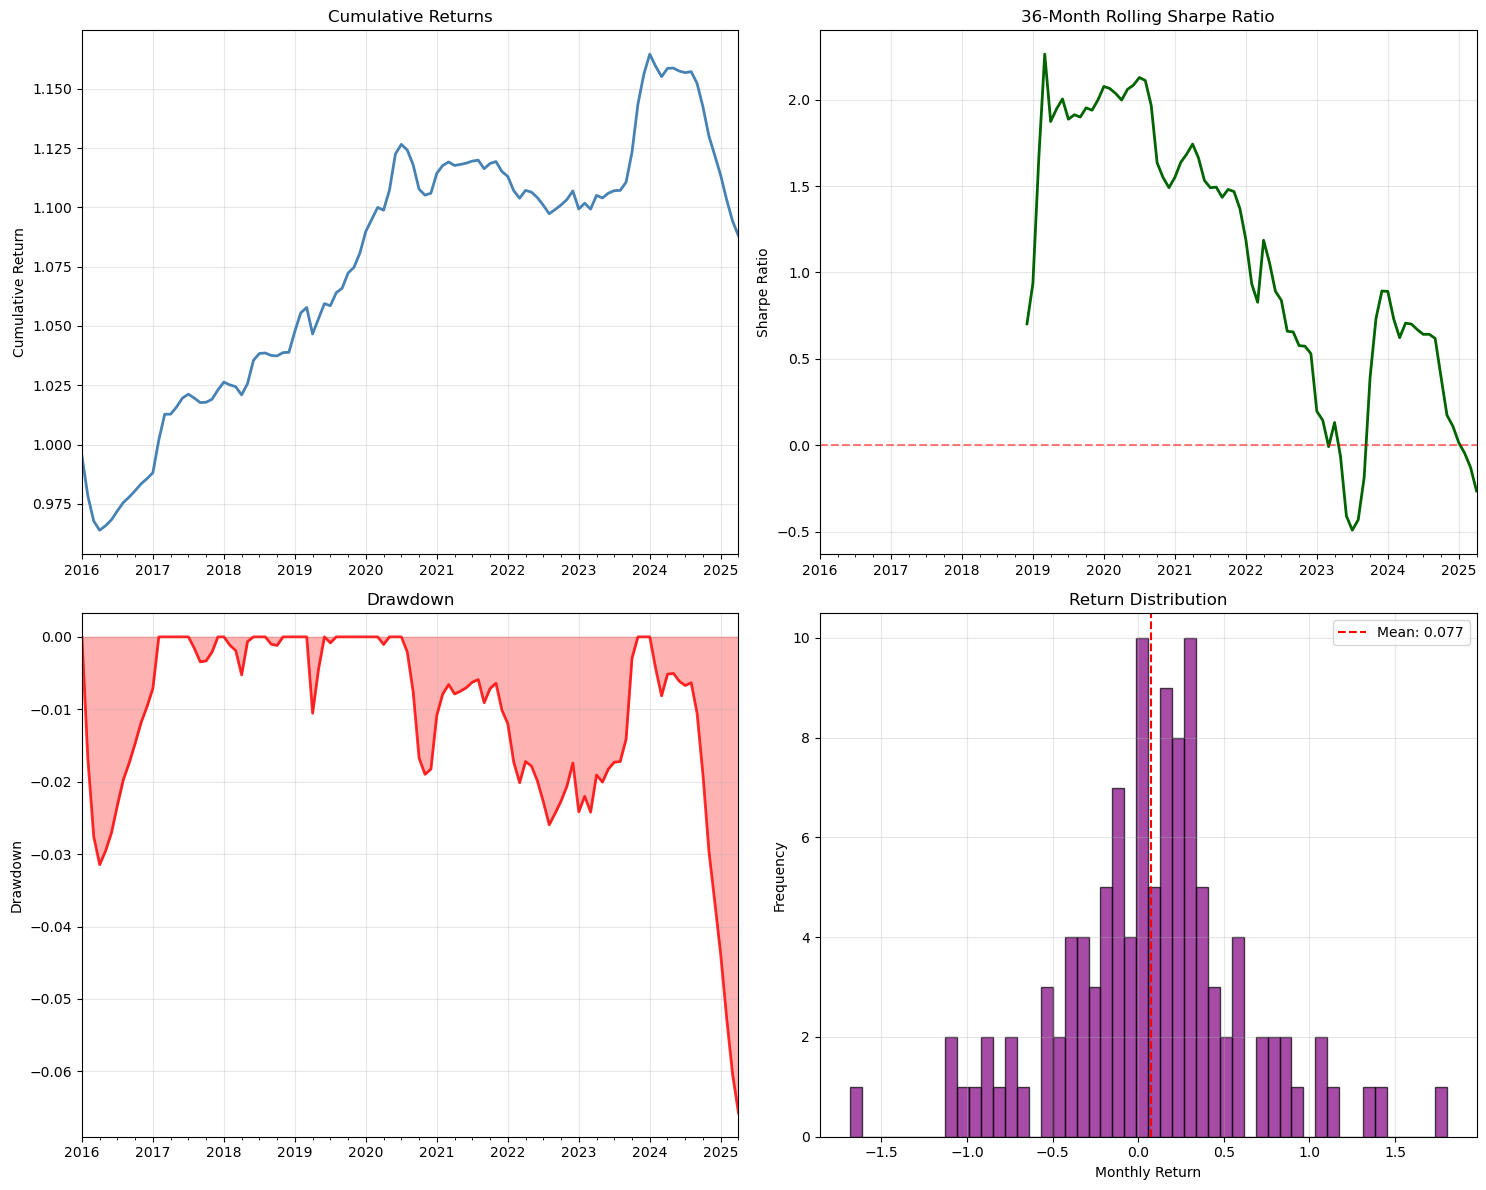


FACTOR TIMING STRATEGY PERFORMANCE REPORT

Performance Period: 2016-01-31 00:00:00 to 2025-04-30 00:00:00
Number of Observations: 112

RETURN METRICS                
------------------------------
Total Return:             8.80%
Annualized Return:        0.93%
Annualized Volatility:    1.90%

RISK-ADJUSTED METRICS         
------------------------------
Sharpe Ratio:             0.485
Max Drawdown:             -1550.45%

DISTRIBUTION METRICS          
------------------------------
Skewness:                 -0.009
Kurtosis:                 1.128
VaR (5%):                 -0.888

REGULARIZATION ANALYSIS       
------------------------------
Average k selected:       6.111
Std of k selected:        4.857
Min k selected:           0.100
Max k selected:           10.000


In [107]:
# Run the enhanced strategy
if __name__ == "__main__":
    # Create sample data (replace with your actual data loading)
    factor_returns, predictors = create_sample_data()
    
    # Initialize and run strategy
    strategy = FactorTimingStrategy(
        factor_returns=factor_returns,
        predictors=predictors,
        rolling_window=240,  # 20 years
        validation_window=12,  # 1 year
        shrinkage_grid=np.linspace(0.1, 10, 20),
        predictor_lag=1  # Lag predictors by 1 period
    )
    
    # Run backtest
    returns = strategy.backtest(factor_returns, predictors)
    
    # Generate results
    strategy.plot_results()
    strategy.generate_report()